In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# تعيين شكل الرسوم البيانية ليكون أكثر وضوحًا
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

In [3]:
# ---------------------------------------------------------------------------
# تحميل البيانات
# ---------------------------------------------------------------------------
print("=============== تحميل ملف البيانات data1.csv ===============")
df = pd.read_csv('data1.csv')
print(f"الشكل الأصلي للبيانات: {df.shape[0]} صفوف و {df.shape[1]} أعمدة")
print(f"عدد القيم المفقودة قبل التنظيف:\n{df.isnull().sum()}\n")


# ---------------------------------------------------------------------------
# التعامل مع القيم المفقودة (Missing Values)
# ---------------------------------------------------------------------------
print("=============== التعامل مع القيم المفقودة ===============")

# العمود 'reviews_per_month': القيم المفقودة تعني على الأرجح عدم وجود تقييمات.
# لذا، سنملأ الفراغات بالصفر.
df['reviews_per_month'].fillna(0, inplace=True)
print("تم ملء القيم المفقودة في 'reviews_per_month' بالصفر.")

# العمود 'last_review': القيم المفقودة هنا مرتبطة بعدم وجود تقييمات.
# يمكننا حذف هذا العمود لأنه تاريخ ولن نستخدمه مباشرة في النماذج.
# الأعمدة 'name' و 'host_name' تحتوي على عدد قليل جدًا من القيم المفقودة، وسنقوم بحذفها لاحقًا على أي حال.


# ---------------------------------------------------------------------------
# الخطوة 3: تصحيح البيانات غير المنطقية
# ---------------------------------------------------------------------------
print("=============== تصحيح البيانات غير المنطقية ===============")

# الأسعار التي تساوي صفر هي على الأغلب بيانات خاطئة أو غير مفيدة لنماذج التوقع.
# سنقوم بحذف الصفوف التي يكون فيها السعر صفرًا.
initial_rows = df.shape[0]
df = df[df['price'] > 0]
rows_removed = initial_rows - df.shape[0]
print(f"تم حذف {rows_removed} صفوف لأن السعر فيها كان يساوي صفرًا.")


# ---------------------------------------------------------------------------
# الخطوة 4: إزالة الأعمدة غير الضرورية
# ---------------------------------------------------------------------------
print("=============== إزالة الأعمدة غير الضرورية للتحليل ===============")

# بعض الأعمدة مثل ID والأسماء لا تقدم معلومات مفيدة لنماذج التنبؤ.
# سنقوم بحذفها لتبسيط مجموعة البيانات.
columns_to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review']
df.drop(columns=columns_to_drop, inplace=True)
print(f"تم حذف الأعمدة التالية: {columns_to_drop}")


# ---------------------------------------------------------------------------
# الخطوة 5: عرض ملخص وحفظ البيانات النظيفة
# ---------------------------------------------------------------------------
print("=============== ملخص بعد عملية التنظيف ===============")
print(f"الشكل النهائي للبيانات النظيفة: {df.shape[0]} صفوف و {df.shape[1]} أعمدة")
print(f"عدد القيم المفقودة بعد التنظيف:\n{df.isnull().sum()}")

# حفظ DataFrame النظيف إلى ملف CSV جديد
df_clean = df.copy() # Assign the DataFrame to df_clean
df_clean.to_csv('cleaned_data.csv', index=False)
print(f"\n🎉 تم حفظ البيانات النظيفة بنجاح في ملف: 'cleaned_data.csv'")

=============== تحميل ملف البيانات data1.csv ===============
الشكل الأصلي للبيانات: 48895 صفوف و 16 أعمدة
عدد القيم المفقودة قبل التنظيف:
id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

=============== التعامل مع القيم المفقودة ===============
تم ملء القيم المفقودة في 'reviews_per_month' بالصفر.
=============== تصحيح البيانات غير المنطقية ===============
تم حذف 11 صفوف لأن السعر فيها كان يسا

/tmp/ipython-input-3923833171.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_per_month'].fillna(0, inplace=True)



🎉 تم حفظ البيانات النظيفة بنجاح في ملف: 'cleaned_data.csv'


=============== مرحلة تحليل البيانات الاستكشافي (EDA) ===============


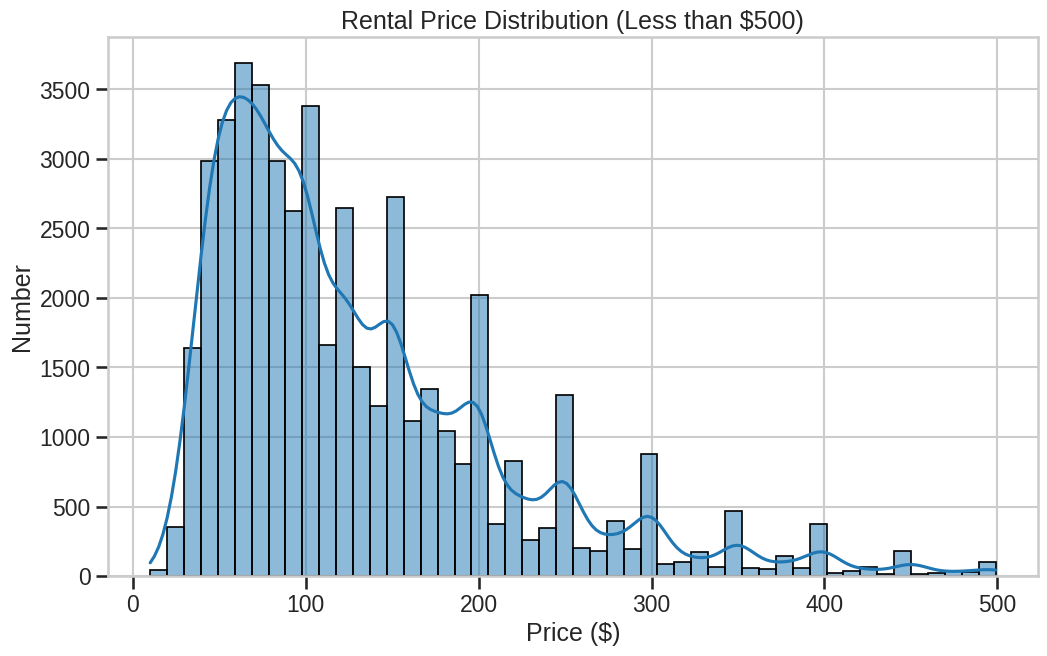

Price distribution chart saved: price_distribution.png


/tmp/ipython-input-3176135654.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, y='neighbourhood_group', order=df_clean['neighbourhood_group'].value_counts().index, palette='viridis')


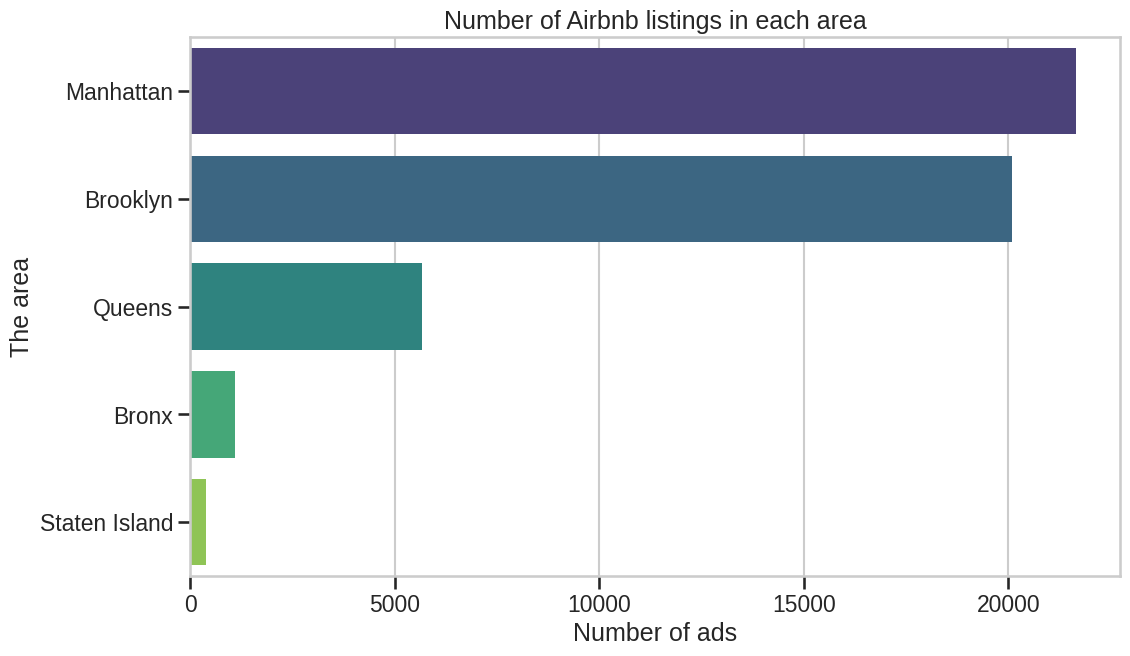

Price distribution chart saved: listings_per_neighbourhood_group.png


/tmp/ipython-input-3176135654.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='room_type', order=df_clean['room_type'].value_counts().index, palette='plasma')


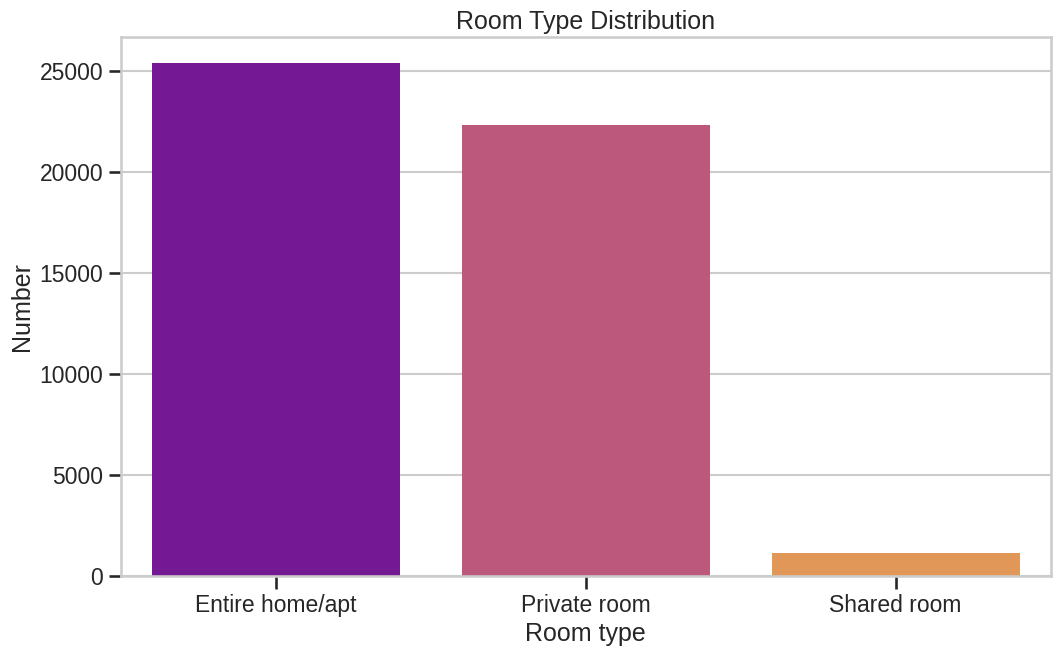

Price distribution chart saved: room_type_distribution.png


/tmp/ipython-input-3176135654.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean[df_clean['price'] < 500], x='neighbourhood_group', y='price', palette='magma')


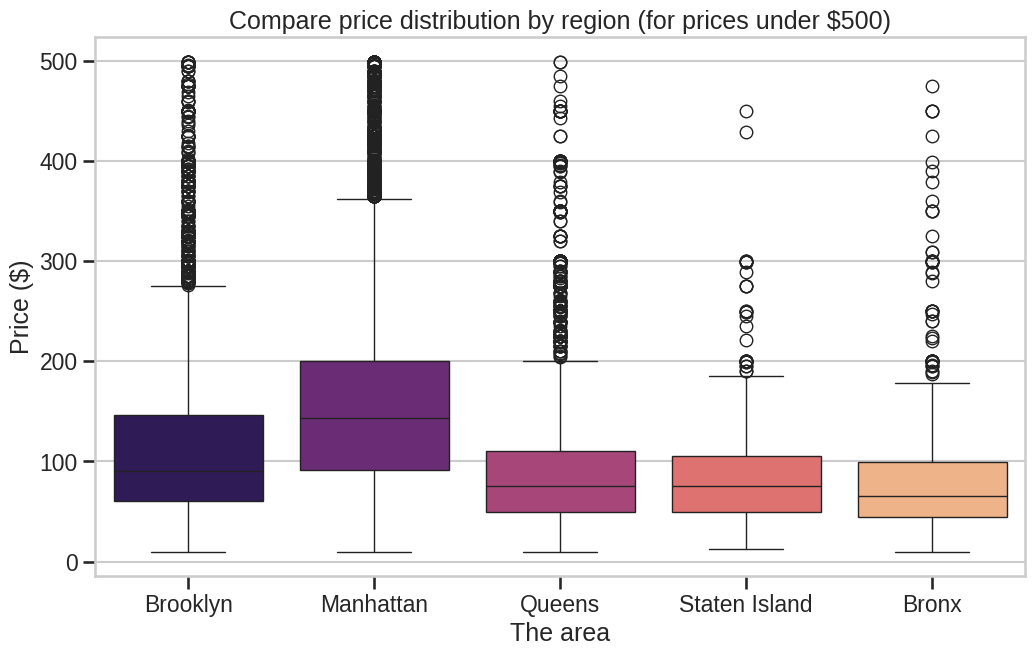

Price distribution chart saved: price_vs_neighbourhood_group.png


In [4]:
# ---------------------------------------------------------------------------
# تحليل البيانات الاستكشافي مع التصور البياني (EDA)
# ---------------------------------------------------------------------------
print("=============== مرحلة تحليل البيانات الاستكشافي (EDA) ===============")

# 1. توزيع الأسعار
# سنقوم بفلترة الأسعار الأعلى من 500 دولار لجعل الرسم البياني أوضح
plt.figure(figsize=(12, 7))
sns.histplot(data=df_clean[df_clean['price'] < 500], x='price', bins=50, kde=True)
plt.title('Rental Price Distribution (Less than $500)')
plt.xlabel('Price ($)')
plt.ylabel('Number')
plt.show()
plt.savefig('price_distribution.png')
plt.close()
print("Price distribution chart saved: price_distribution.png")

# 2. عدد الإعلانات حسب المنطقة
plt.figure(figsize=(12, 7))
sns.countplot(data=df_clean, y='neighbourhood_group', order=df_clean['neighbourhood_group'].value_counts().index, palette='viridis')
plt.title('Number of Airbnb listings in each area')
plt.xlabel('Number of ads')
plt.ylabel('The area')
plt.show()
plt.savefig('listings_per_neighbourhood_group.png')
plt.close()
print("Price distribution chart saved: listings_per_neighbourhood_group.png")

# 3. توزيع أنواع الغرف
plt.figure(figsize=(12, 7))
sns.countplot(data=df_clean, x='room_type', order=df_clean['room_type'].value_counts().index, palette='plasma')
plt.title('Room Type Distribution')
plt.xlabel('Room type')
plt.ylabel('Number')
plt.show()
plt.savefig('room_type_distribution.png')
plt.close()
print("Price distribution chart saved: room_type_distribution.png")

# 4. مقارنة الأسعار حسب المنطقة
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_clean[df_clean['price'] < 500], x='neighbourhood_group', y='price', palette='magma')
plt.title('Compare price distribution by region (for prices under $500)')
plt.xlabel('The area')
plt.ylabel('Price ($)')
plt.show()
plt.savefig('price_vs_neighbourhood_group.png')
plt.close()
print("Price distribution chart saved: price_vs_neighbourhood_group.png")

In [5]:
# ---------------------------------------------------------------------------
# تجهيز البيانات لمرحلة التعلم الإشرافي
# ---------------------------------------------------------------------------
print("=============== تجهيز البيانات للتعلم الإشرافي ===============")


# تحديد المتغيرات العددية والفئوية التي سنستخدمها
# الميزات العددية
numeric_features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
# الميزات الفئوية
categorical_features = ['room_type', 'neighbourhood_group'] # Added 'room_type' to categorical features
# المتغير المستهدف
target = 'price'

# فصل الميزات عن المتغير المستهدف
X = df[numeric_features + categorical_features]
y = df[target]

# تقسيم البيانات إلى مجموعة تدريب ومجموعة اختبار
# 80% للتدريب و 20% للاختبار
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Removed stratify=y

print(f"حجم بيانات التدريب: {X_train.shape[0]} صف")
print(f"حجم بيانات الاختبار: {X_test.shape[0]} صف")

# بناء أنابيب المعالجة (Pipelines) لتجهيز البيانات
# توحيد قياس المتغيرات الرقمية وتحويل المتغيرات الفئوية
# معالج المتغيرات العددية: يقوم بتوحيد قياسها (Scaling)
numeric_transformer = StandardScaler()
# معالج المتغيرات الفئوية: يقوم بتحويلها إلى أرقام (One-Hot Encoding)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# دمج المعالجين في معالج واحد باستخدام ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

=============== تجهيز البيانات للتعلم الإشرافي ===============
حجم بيانات التدريب: 39107 صف
حجم بيانات الاختبار: 9777 صف


In [7]:
# ---------------------------------------------------------------------------
# بناء وتدريب وتقييم نماذج التعلم الإشرافي
# ---------------------------------------------------------------------------
print("=============== بناء وتقييم نماذج التعلم الإشرافي ===============")

# تعريف النماذج التي سنستخدمها
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors (KNN)": KNeighborsClassifier(n_neighbors=15),
}

# حلقة لتكرار عملية التدريب والتقييم لكل نموذج
for name, model in models.items():
    print(f"=============== تقييم نموذج: {name} ===============")

    # إنشاء خط عمل (Pipeline) يربط بين معالجة البيانات والنموذج
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # تدريب النموذج
    pipeline.fit(X_train, y_train)

    # إجراء التنبؤات على بيانات الاختبار
    y_pred = pipeline.predict(X_test)

    # حساب وعرض مقاييس الأداء
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # عرض مصفوفة الارتباك (Confusion Matrix)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # plt.show()
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_")}.png')
    plt.close() # نغلق الشكل لتجنب عرضه مباشرة هنا


=============== بناء وتقييم نماذج التعلم الإشرافي ===============
=============== تقييم نموذج: Logistic Regression ===============
Accuracy: 0.0724

Classification Report:
              precision    recall  f1-score   support

          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         9
          22       0.00      0.00      0.00         5
          23       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          25       0.11      0.04      0.06        23
          26       0.00      0.00      0.00         4
          27       0.00      0.00      0.00         5
          28     

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

=============== تقييم نموذج: K-Nearest Neighbors (KNN) ===============
Accuracy: 0.0625

Classification Report:
              precision    recall  f1-score   support

          10       0.00      0.00      0.00         4
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         9
          21       0.00      0.00      0.00         0
          22       0.12      0.20      0.15         5
          23       0.00      0.00      0.00         1
          24       0.00      0.00      0.00         1
          25       0.18      0.22      0.20        23
          26       0.00      0.00      0.00         4
          27       0.00      0.00      0.00         5
          28       0.55

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

In [8]:
# ---------------------------------------------------------------------------
# تجهيز البيانات وتطبيق خوارزمية K-Means (التعلم غير الإشرافي)
# ---------------------------------------------------------------------------
print("=============== تطبيق خوارزمية K=====Means (التعلم غير الإشرافي) ===============")

# اختيار الميزات لعملية التجميع: الموقع الجغرافي والسعر
# سنقوم بأخذ عينة صغيرة من البيانات لتسريع العملية وتسهيل التصور
kmeans_df = df_clean[['latitude', 'longitude', 'price']].copy()
kmeans_df_sample = kmeans_df[kmeans_df['price'] < 500].sample(n=10000, random_state=42) # فلترة الأسعار المرتفعة جداً وأخذ عينة

# توحيد قياس البيانات (Scaling) لأن K-Means حساسة لمقاييس المتغيرات
scaler = StandardScaler()
kmeans_scaled = scaler.fit_transform(kmeans_df_sample)

# استخدام طريقة الكوع (Elbow Method) لتحديد العدد الأمثل للمجموعات (K)
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(kmeans_scaled)
    sse.append(kmeans.inertia_)

# رسم بياني لطريقة الكوع
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_range)
plt.savefig('kmeans_elbow_method.png')
plt.close()

# من الرسم البياني، سنختار العدد الأمثل للمجموعات (عادةً ما يكون عند "الكوع")
# لنفترض أن K=4 هو الخيار الأفضل
optimal_k = 4
print(f"\nتم اختيار العدد الأمثل للمجموعات K = {optimal_k}")

# تطبيق K-Means باستخدام العدد الأمثل للمجموعات
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(kmeans_scaled)

# إضافة labels المجموعات إلى بيانات العينة
kmeans_df_sample['cluster'] = kmeans.labels_


=============== تطبيق خوارزمية K=====Means (التعلم غير الإشرافي) ===============

تم اختيار العدد الأمثل للمجموعات K = 4


In [9]:
# ---------------------------------------------------------------------------
# الخطوة الخامسة: تصور نتائج K-Means
# ---------------------------------------------------------------------------
print("=============== تصور نتائج K=====Means ===============")
# رسم المجموعات على خريطة مبعثرة (Scatter Plot)
plt.figure(figsize=(12, 10))
sns.scatterplot(data=kmeans_df_sample, x='longitude', y='latitude', hue='cluster', palette='viridis', s=50, alpha=0.7)
plt.title('NYC Airbnb Listings Clusters (K-Means)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster')
plt.savefig('kmeans_clusters.png')
plt.close()

print("\n--- انتهى التنفيذ بنجاح! ---")
print("تم حفظ جميع الرسوم البيانية كملفات صور في مجلد العمل.")

=============== تصور نتائج K=====Means ===============

--- انتهى التنفيذ بنجاح! ---
تم حفظ جميع الرسوم البيانية كملفات صور في مجلد العمل.
